## Task 1: Solving the diffusion equation in r (under the no-z approximation)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
fig_path = "figures/Task-1/"
fig_save = True

In [183]:
# defining spatial deritivative functions
def spatial_derivative(B, dx, order = 2, ghost_zone_type = 'symmetric'):
   
    dBdx = np.zeros(B.shape)
    ddBddx = np.zeros(B.shape)

    # print(f"The shape of B is {B.shape}")
    # print(f"The shape of dBdx is {dBdx.shape}")
    # print(f"The shape of ddBddx is {ddBddx.shape}")
    
    B = np.copy(B) # to avoid modifying the original array
    
    if order not in ['np',2, 4]:
        raise ValueError("Order should be 'np' = 2 or 4")
    
    if ghost_zone_type not in ['anti-symmetric', 'symmetric', 'smooth',None]:
        raise ValueError('ghost_zone_type should be anti-symmetric, symmetric or None')

    if order == 'np':
        ghost_zone = 5 # 5 cells on each side
    else:
        ghost_zone = int(order/2)
    
    if ghost_zone_type == 'anti-symmetric':
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='reflect') # makes symmetric padding
        for i in range(ghost_zone): 
            B[:,i] = - B[:, i] # making anti-symmetric at the start of the array
            B[:, -1 - i] = - B[:, -1 - i] # making anti-symmetric at the end of the array
            
    elif ghost_zone_type == 'symmetric':
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='symmetric')
        
    elif ghost_zone_type == 'smooth':
        Y = np.pad(Y, (ghost_zone, ghost_zone), mode='reflect', reflect_type='odd')
        
    else:
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='constant') # zero padding

    if order == 2:
        for i in range(ghost_zone, B.shape[1] - ghost_zone):
            dBdx[:,i-ghost_zone] = ((- B[:,i - 1]) + (B[:,i + 1])) / (2 * dx)
            ddBddx[:,i-ghost_zone] = (B[:,i - 1] - (2 * B[:, i]) + B[:,i + 1]) / (dx ** 2)
    elif order == 4:
        for i in range(ghost_zone, B.shape[1] - ghost_zone):
            dBdx[:,i-ghost_zone] = ((B[:,i - 2]) - (8 * B[:,i - 1]) + (8 * B[:,i + 1]) - (B[:,i + 2])) / (12 * dx)
            ddBddx[:,i-ghost_zone] = ((- B[:,i - 2]) + (16 * B[:,i - 1]) - (30 * B[:,i]) + (16 * B[:,i + 1]) - (B[:,i + 2])) / (12 * (dx ** 2))
    else:
        dBdx = np.gradient(B, dx, axis=1)
        ddBddx = np.gradient(dBdx, dx, axis=1)
        
        # removing the ghost zones
        dBdx = dBdx[:,ghost_zone:-ghost_zone]
        ddBddx = ddBddx[:,ghost_zone:-ghost_zone]
            
    
    return dBdx, ddBddx

In [174]:
def sim_field(r_i, r_f, Nr, T, Nt, B_r0, B_phi0, dBdt_r, order = 4, ghost_zone_type = 'symmetric', iterations_to_save = None):

    dr = (r_f - r_i) / (Nr - 1)  # Spatial step size
    dt = T / Nt  # Time step size
    
    # Create arrays to store the solution in time
    B_list = []

    # creating initial conditions from z, B_r0 and B_phi0
    
    r = np.linspace(r_i, r_f, Nr)
    r_ = np.array([r,r]) # Under the assumption that the equation is same for both B_r and B_phi
                         # We need this r_ for the equation
    
    B = np.zeros((2, Nr))
    B[0, :] = B_r0(r, 0, 0) # first row is B_r
    B[1, :] = B_phi0(r, 0, 0) # second row is B_phi
    
    if iterations_to_save is None:
        iterations_to_save = [0, Nt]
    elif iterations_to_save == 'all':
        iterations_to_save = list(range(Nt + 1))

    if 0 in iterations_to_save:
        B_list.append(np.copy(B))
    
    # RK4 time-stepping block 
    
    for n in tqdm(range(1, Nt + 1)):
        # Compute spatial derivatives
        dBdr, ddBddr = spatial_derivative(B, dr, order, ghost_zone_type)


        k1 = dBdt_r(B, r_, dBdr, ddBddr, n * dt)
        k2 = dBdt_r(B + (0.5 * dt * k1), r_, dBdr, ddBddr, (n * dt) + (0.5 * dt))
        k3 = dBdt_r(B + (0.5 * dt * k2), r_, dBdr, ddBddr, (n * dt) + (0.5 * dt))
        k4 = dBdt_r(B + (dt * k3), r_, dBdr, ddBddr, (n * dt) + dt)
        
        B = B + (dt / 6.0) * (k1 + (2 * k2) + (2 * k3) + k4)
        
        # print(B)
        
        if n in iterations_to_save:
            B_list.append(np.copy(B))
    
    B_list = np.array(B_list)
    
    return B_list


In [175]:
# defining constants and parameters
eta = 1
r_i = 0.01  # start of spatial domain
r_f = 10.01 # end of spatial domain
T = 1.0  # Total simulation time
Nr = 100  # Number of spatial grid points
Nt_r = 5000  # Number of time steps
h = 1
delta = 0.00001 # for avoiding division by zero


r_i = r_i + delta
r_f = r_f + delta

t = np.linspace(0, T, Nt_r + 1)
r = np.linspace(r_i, r_f, Nr)
B = np.zeros((2, Nr))

order = 'np'
order = 4
ghost_zone_type = 'symmetric'

iterations_to_save = [int(i * Nt_r/8) for i in range(8 + 1)] # which time steps to save

# defining initial conditions keeping B_r = 0 to explore the evolutions clearly

def B_phi0_r(r, phi, z):
    return 0
def B_r0_r(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) + (1.5*np.sin(((r - r_i)/(r_f - r_i))*6*np.pi)) + ( np.sin(((r - r_i)/(r_f - r_i))*1*np.pi))



# definiing the time evolution of the magnetic field
def dBdt_r(B, r_, dBdr, ddBdr, t):
    return eta * (ddBdr + (dBdr / r_) - (B/(r_ ** 2)) - (((np.pi ** 2) / (4 * (h**2))) * B))

In [176]:
def plot_animate(U, tspan, xspan, fps, r_i, r_f, name):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(r_i, r_f)
    ax.set_ylim(-1, 8)
    ax.set_xlabel('r')
    ax.set_ylabel(f'{str(name)}(r,t)')
    ax.set_title(f'{str(name)}(r,t)')

    line, = ax.plot([], [], lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(xspan, U[i])
        return line,

    ani = animation.FuncAnimation(fig, animate, frames=len(tspan), init_func=init, blit=True)
    writer = animation.FFMpegWriter(fps=fps)
    ani.save(name + '.mp4', writer=writer)
#     ani = animation.FuncAnimation(fig, animate, frames=len(tspan), init_func=init, blit=True)
#     ani.save(name+'.gif', writer='pillow', fps=fps) 
    
    # Use FFMpegWriter and save as MP4



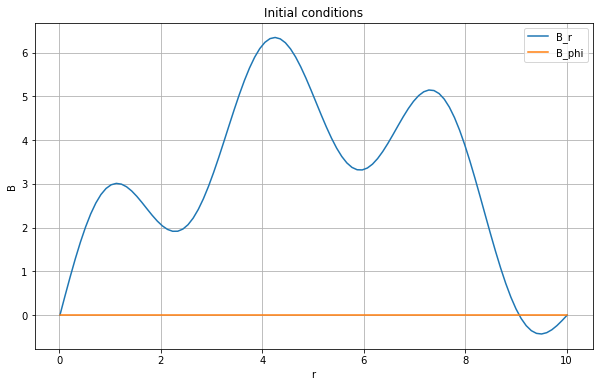

In [14]:
# plotting initial magnetic field

plt.figure(figsize=(10, 6))
B[0, :] = B_r0_r(r, 0, 0) # first row is B_r
B[1, :] = B_phi0_r(r, 0, 0) # second row is B_phi

plt.plot(r, B[0, :], label = 'B_r')
plt.plot(r, B[1, :], label = 'B_phi')

plt.xlabel('r')
plt.ylabel('B')
plt.grid(True)
plt.title('Initial conditions')
plt.legend()
plt.savefig(fig_path + "B_r_init.png")
plt.show()

In [16]:
# To get every time step
B_list0 = sim_field(r_i, r_f, Nr, T, Nt_r, B_r0_r, B_phi0_r, dBdt_r, order, ghost_zone_type, iterations_to_save='all')

100%|██████████| 5000/5000 [00:05<00:00, 874.67it/s]


#### B_total = [B_phi^2 + B_r^2]^1/2 = B_phi as B_r = 0

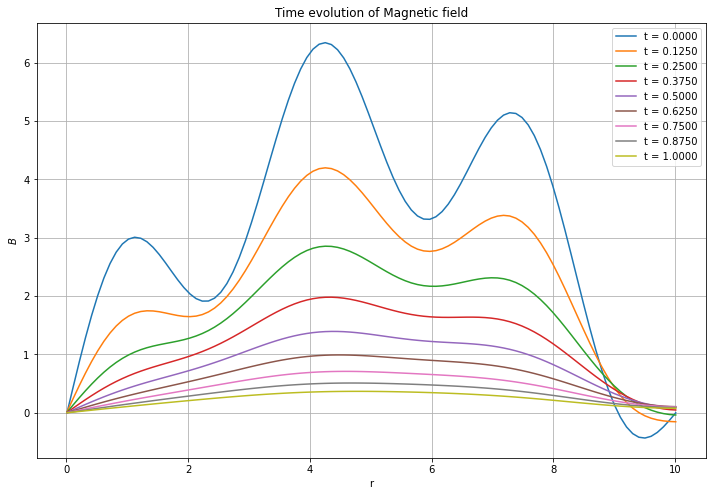

In [181]:
# plotting the results

plt.figure(figsize=(12, 8))
plt.title(r'Time evolution of Magnetic field')
plt.xlabel(r'r')
plt.ylabel(r'$B$')
plt.grid(True)
for i in range(len(iterations_to_save)):
    plt.plot(np.linspace(r_i, r_f, Nr), B_list0[iterations_to_save[i], 0, :], label=f't = {iterations_to_save[i] * T / Nt_r:.4f}')
plt.legend()
if fig_save:
    plt.savefig(fig_path + "B_r_evol.png")
plt.show()

#plot_animate(B_list0[:, 0, :],t, r, 500, r_i, r_f, 'B')



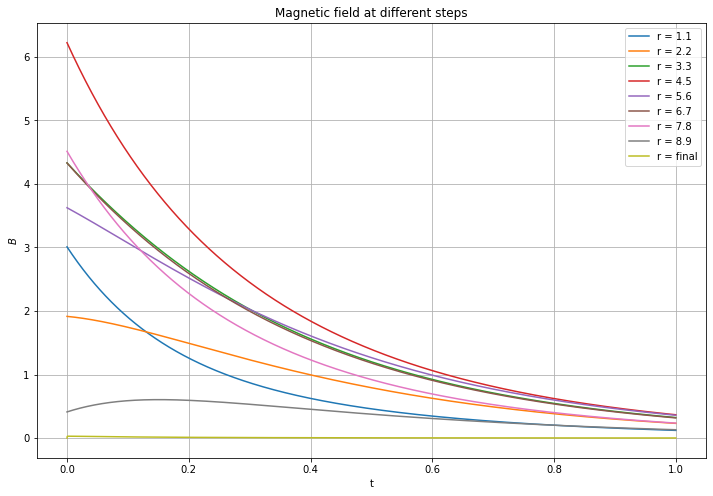

In [180]:
r = np.linspace(r_i, r_f, 10) # 10 points to exclude the boundaries
r = r[1:-1]

spacesteps_to_save = np.linspace(0, Nr - 1,10, dtype = int) # 10 points to exclude the boundaries
spacesteps_to_save = spacesteps_to_save[1:-1]

# plotting the magnetic field at different time steps
plt.figure(figsize=(12, 8))
plt.title(r'Magnetic field at different steps')
plt.xlabel(r't')
plt.ylabel(r'$B$')
for i in range(len(spacesteps_to_save)):
    plt.plot(np.linspace(0, T, Nt_r + 1), abs(B_list[:, 0, spacesteps_to_save[i]]), label=f'r = {r[i]:.1f}')
plt.plot(t_r, abs(B_list[:, 0, 0]), label=f'r = final')
plt.grid(True)
plt.legend()
if fig_save:
    plt.savefig(fig_path + "B_r_ts.png")
plt.show()



The decay rate, gamma, is -2.5791


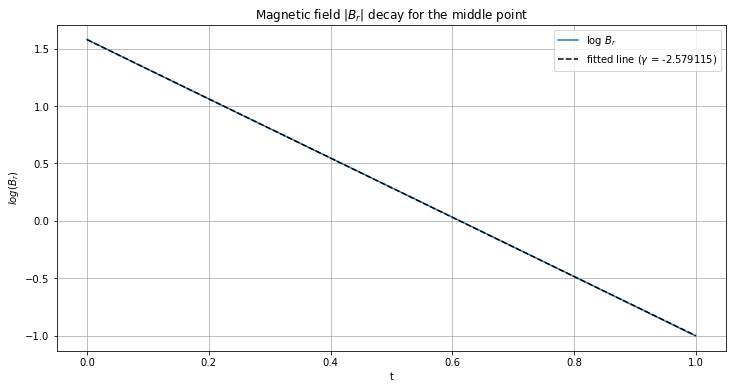

In [182]:
# calculating the decay rate for the middle point
midr = int(Nr/2)
B_phi_midr = abs(B_list[:, 0, midr])
log_B_phi_midr = np.log(B_phi_midr)
# print(len(t), len(B_phi_midr))

slope, intercept = np.polyfit(t, log_B_phi_midr, 1)
print(f"The decay rate, gamma, is {slope:.4f}")

# plotting the magnetic field decay and fitting
plt.figure(figsize=(12, 6))
plt.title(r'Magnetic field $|B_{r}|$ decay for the middle point')
plt.xlabel(r't')
plt.ylabel(r'$log(B_{r})$')
plt.plot(t, log_B_phi_midr, label = 'log $B_{r}$')
plt.plot(t, slope*t + intercept,'k--', label = f'fitted line ($\gamma$ = {slope : 4f})')
plt.grid(True)
plt.legend()
if fig_save:
    plt.savefig(fig_path + "B_r_decay.png")
plt.show()

## Initial condition 2

In [159]:
# defining both the initial conditions for the magnetic field
r = np.linspace(r_i, r_f, 5000)

def B_phi0_r(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*5*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*4*np.pi))

def B_r0_r(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) + (1.5*np.sin(((r - r_i)/(r_f - r_i))*6*np.pi)) + ( np.sin(((r - r_i)/(r_f - r_i))*1*np.pi))

B_list0 = sim_field(r_i, r_f, Nr, T, Nt_r, B_r0_r, B_phi0_r, dBdt_r, order, ghost_zone_type, iterations_to_save='all')


100%|██████████| 5000/5000 [00:05<00:00, 879.31it/s]


5000 5000


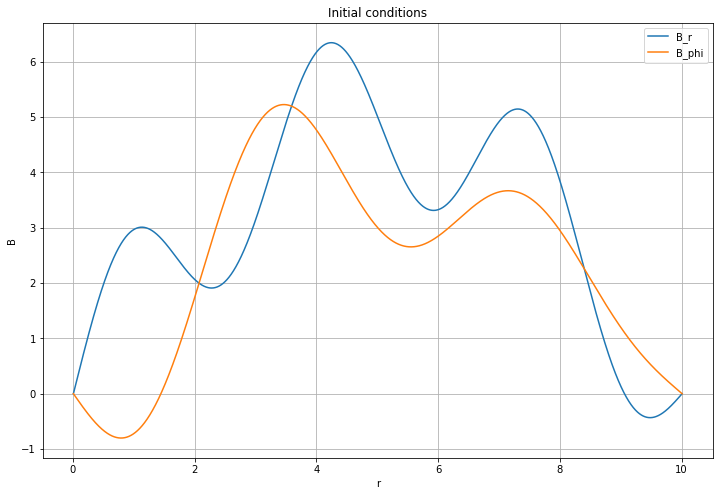

In [160]:
# plotting initial magnetic field
B = np.zeros((2, 5000))
B[0, :] = B_r0_r(r, 0, 0) # first row is B_r
B[1, :] = B_phi0_r(r, 0, 0) # second row is B_phi

print(len(r), len(B[0,:]))
plt.figure(figsize=(12, 8))
plt.plot(r, B[0, :], label = 'B_r')
plt.plot(r, B[1, :], label = 'B_phi')

plt.xlabel('r')
plt.ylabel('B')
plt.grid(True)
plt.title('Initial conditions')
plt.legend()
plt.savefig(fig_path + "Br_Bphi_init2.png")
plt.show()

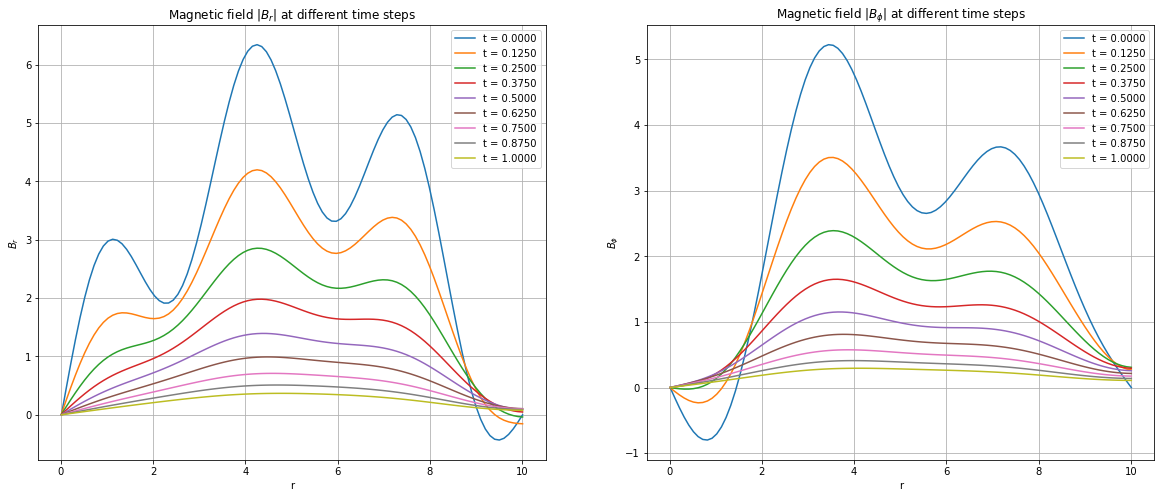

In [161]:
# each plot has spatial domain in x-axis and magnetic field in y-axis

fig, axs = plt.subplots(1,2, figsize=(20, 8))
# B_r
axs[0].set_title(r'Magnetic field $|B_{r}|$ at different time steps')
axs[0].set_xlabel(r'r')
axs[0].set_ylabel(r'$B_{r}$')
for i in range(len(iterations_to_save)):
    axs[0].plot(np.linspace(r_i, r_f, Nr), B_list0[iterations_to_save[i], 0, :], label=f't = {iterations_to_save[i] * T / Nt_r:.4f}')
axs[0].grid(True)
axs[0].legend()

# B-phi
axs[1].set_title(r'Magnetic field $|B_{\phi}|$ at different time steps')
axs[1].set_xlabel(r'r')
axs[1].set_ylabel(r'$B_{\phi}$')
for i in range(len(iterations_to_save)):
    axs[1].plot(np.linspace(r_i, r_f, Nr), B_list0[iterations_to_save[i], 1, :], label=f't = {iterations_to_save[i] * T / Nt_r:.4f}')
axs[1].grid(True)
axs[1].legend()

if fig_save:
    plt.savefig(fig_path + "Bphi_Br_evol.png")
plt.show()



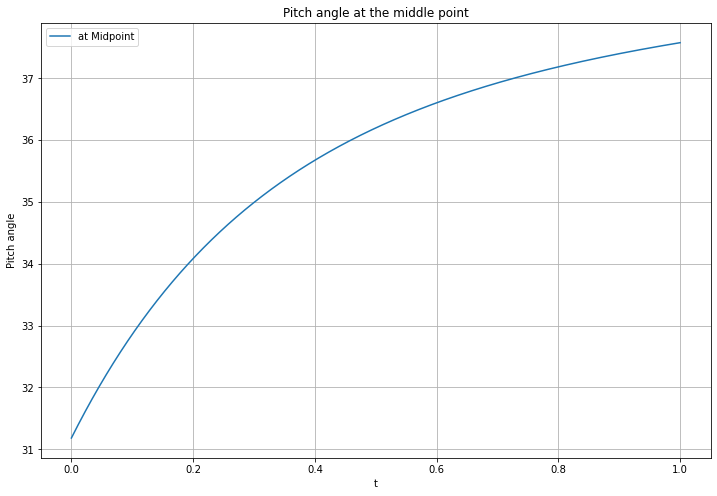

In [162]:

midr = int(Nr/2)


B_phi_midr = B_list0[:, 1, midr]
B_r_midr = B_list0[:, 0, midr]
pitch_angle_mid = np.arctan(B_phi_midr/B_r_midr)
t_r = np.linspace(0, T, Nt_r + 1)

# converting to degrees
pitch_angle_mid = pitch_angle_mid * 180 / np.pi

# plotting the pitch angle for both z and r implementations
plt.figure(figsize=(12, 8))
plt.title(r'Pitch angle at the middle point')
plt.xlabel(r't')
plt.ylabel(r'Pitch angle')
plt.plot(t_r, pitch_angle_mid, label = 'at Midpoint')
plt.grid(True)
plt.legend()
if fig_save:
    plt.savefig(fig_path + "pitch_angle_r_mid.png")
plt.show()



/tmp/ipykernel_486411/2985046714.py:21: RuntimeWarning: invalid value encountered in divide
  pitch_angle_t[i, :] = np.arctan(B_phi/B_r)


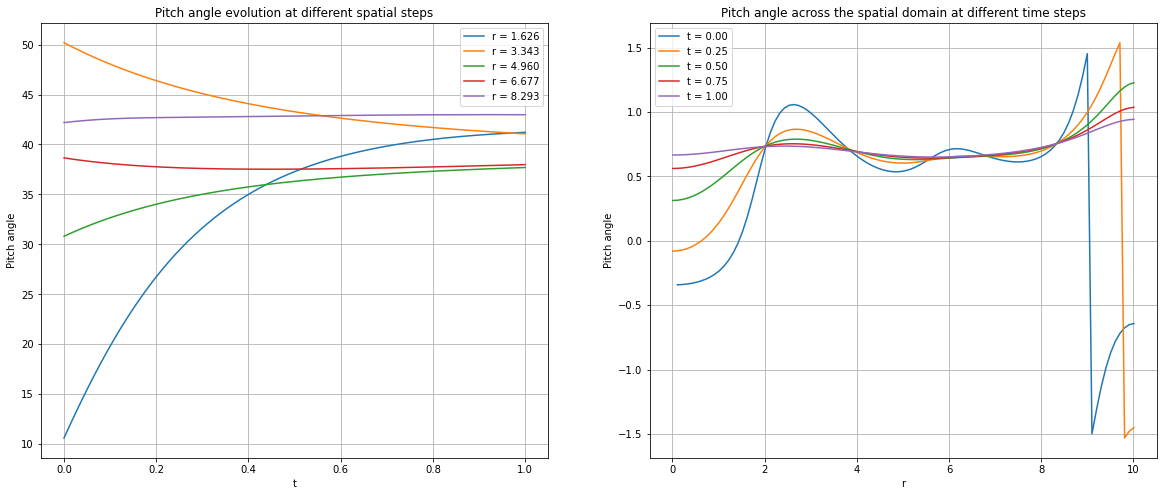

In [169]:
space_steps_to_save = np.linspace(0, Nr - 1, 7, dtype = int) # 8 points to exclude the boundaries
space_steps_to_save = space_steps_to_save[1:-1]

iterations_to_save2 = [int(i * Nt_r/4) for i in range(4 + 1)] # which time steps to save


# spatial evolution
pitch_angle_r = np.zeros((len(space_steps_to_save), Nt_r + 1))
for i in range(len(space_steps_to_save)):
    B_phi = B_list0[:, 1, space_steps_to_save[i]]
    B_r = B_list0[:, 0, space_steps_to_save[i]]
    pitch_angle_r[i, :] = np.arctan(B_phi/B_r)
    
pitch_angle_r = pitch_angle_r * 180 / np.pi

# time evolution
pitch_angle_t = np.zeros((len(iterations_to_save2), Nr))
for i in range(len(iterations_to_save2)):
    B_phi = B_list0[iterations_to_save2[i], 1, :]
    B_r = B_list0[iterations_to_save2[i], 0, :]
    pitch_angle_t[i, :] = np.arctan(B_phi/B_r)
       

fig, axs = plt.subplots(1,2, figsize=(20, 8))
axs[0].set_title(r'Pitch angle evolution at different spatial steps')
axs[0].set_xlabel(r't')
axs[0].set_ylabel(r'Pitch angle')
for i in range(len(iterations_to_save2)):
    axs[0].plot(t_r, pitch_angle_r[i, :], label = f'r = {r_i + (space_steps_to_save[i] * (r_f - r_i) / (Nr - 1)):.3f}')
axs[0].grid(True)
axs[0].legend()

axs[1].set_title(r'Pitch angle across the spatial domain at different time steps')
axs[1].set_xlabel(r'r')
axs[1].set_ylabel(r'Pitch angle')
for i in range(len(iterations_to_save2)):
    axs[1].plot(np.linspace(r_i, r_f, Nr), pitch_angle_t[i, :], label = f't = {iterations_to_save2[i] * T / Nt_r:.2f}')
axs[1].grid(True)
axs[1].legend()


if fig_save:
    plt.savefig(fig_path + "pitch_angle_evolution.png")
plt.show()

In [170]:
def B_total(Blist):
    B_tot = [(np.sqrt(B_r**2 + B_phi**2)) for B_r, B_phi in zip(B_list0[ : , 0, :], B_list0[ : , 1, :])]
    B_tot = np.array(B_tot)
    #rint(B_tot.shape)
    #rint(B_tot[0].shape)
    return B_tot

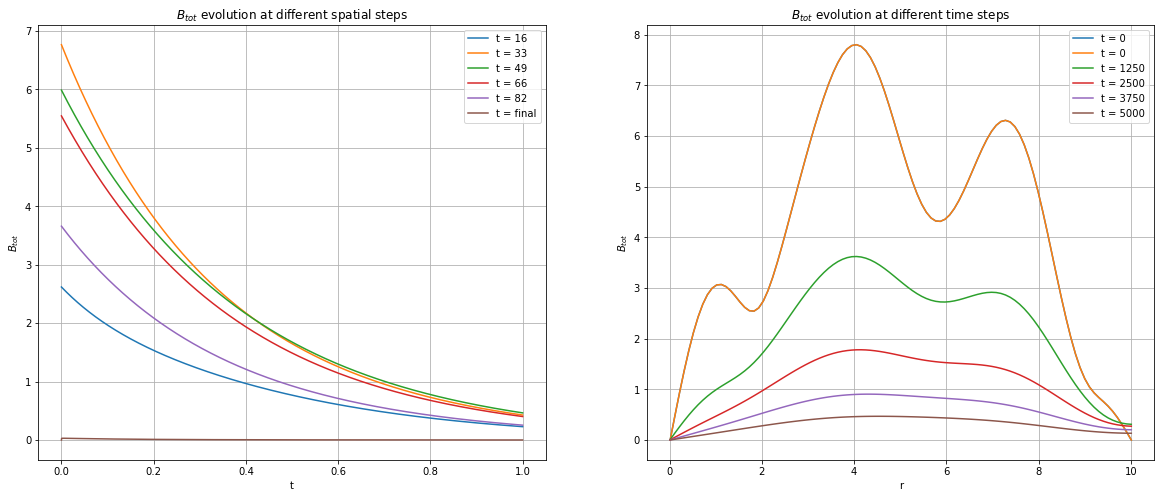

In [178]:
B_tot = B_total(B_list0)

fig, axs = plt.subplots(1,2, figsize=(20, 8))
axs[0].set_title(r'$B_{tot}$ evolution at different spatial steps')
axs[0].set_xlabel(r't')
axs[0].set_ylabel(r'$B_{tot}$')

for i in range(len(space_steps_to_save)):
    axs[0].plot(t_r, B_tot[:,space_steps_to_save[i]], label = f't = {space_steps_to_save[i]}')
axs[0].plot(t_r, B_tot[:,0],label = f't = final')    

axs[0].grid(True)
axs[0].legend()

axs[1].set_title(r'$B_{tot}$ evolution at different time steps')
axs[1].set_xlabel(r'r')
axs[1].set_ylabel(r'$B_{tot}$')
axs[1].plot(r, B_tot[0,:],label = f't = 0')
for i in range(len(iterations_to_save2)):
    axs[1].plot(np.linspace(r_i, r_f, Nr), B_tot[iterations_to_save2[i],:], label = f't = {iterations_to_save2[i]}')
axs[1].grid(True)
axs[1].legend()


if fig_save:
    plt.savefig(fig_path + "B_evolution2.png")
plt.show()



In [168]:
#plot_animate(B_tot,t, r, 800,r_i, r_f, 'Btot')

The decay rate, gamma, is -2.5904



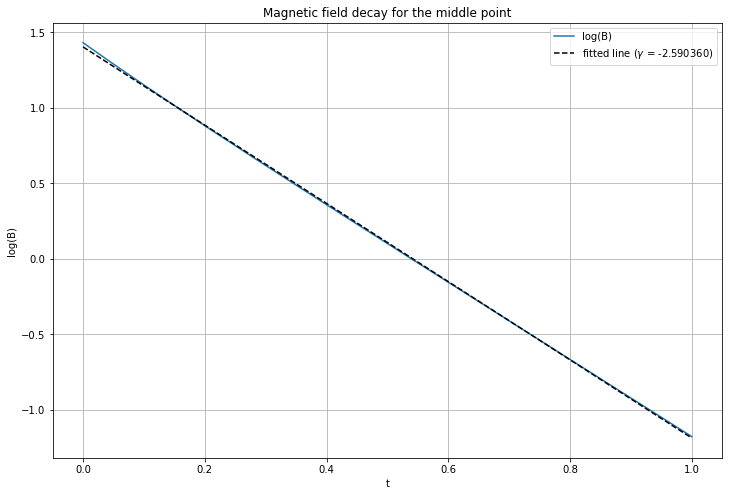

In [110]:
# calculating the decay rate for the middle point
mean_B = np.mean(B_tot, axis=1)
#print(mean_B.shape)
midr = int(Nr/2)
#print(B_tot)  
B_midr = np.abs(mean_B)
log_B_midr = np.log(B_midr)
#print(len(t), len(B_midr),len(space_steps_to_save))

slope, intercept = np.polyfit(t, log_B_midr, 1)
slope = float(slope)
print(f"The decay rate, gamma, is {slope:.4f}")
print()
# plotting the magnetic field decay and fitting
plt.figure(figsize=(12,8))
plt.title(r'Magnetic field decay for the middle point')
plt.xlabel(r't')
plt.ylabel(r'log(B)') 
plt.plot(t, log_B_midr, label = 'log(B)')
plt.plot(t, slope*t + intercept,'k--', label = f'fitted line ($\gamma$ = {slope : 4f})')
plt.grid(True)
plt.legend()
if fig_save:
    plt.savefig(fig_path + "B_decay.png")
plt.show()



In [32]:
#plot_animate(B_list0[:, 0, :],t, r, 800, r_i, r_f, '$B_r$')
#plot_animate(B_list0[:, 1, :],t, r, 800, r_i, r_f, '$B_\phi$')

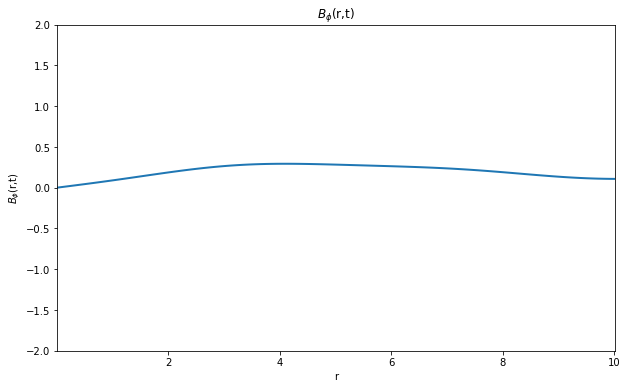

In [33]:
#plot_animate(B_list0[:, 0, :],t, r, 50, r_i, r_f, '$B_{r}$')
plot_animate(B_list0[:, 1, :],t, r, 50, r_i, r_f, '$B_{\phi}$')

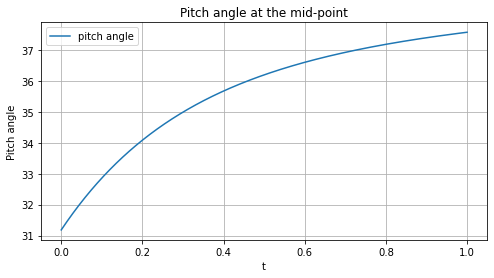

/tmp/ipykernel_486411/2001353982.py:35: RuntimeWarning: invalid value encountered in divide
  pitch_angle_r[i, :] = np.arctan(B_phi/B_r)


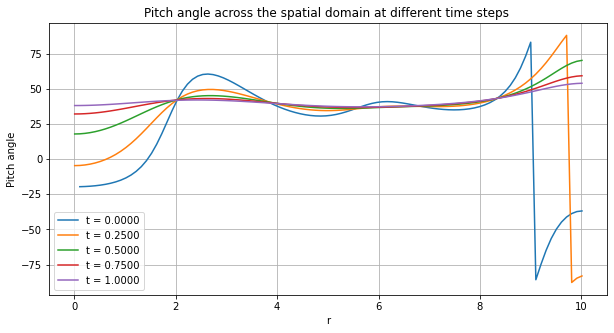

In [34]:
# computing pitch angle at middle point for r implementations

midr = int(Nr/2)

B_phi_midr = B_list0[:, 1, midr]
B_r_midr = B_list0[:, 0, midr]

pitch_angle_r = np.arctan(B_phi_midr/B_r_midr)

t_r = np.linspace(0, T, Nt_r + 1)

# converting to degrees
pitch_angle_r = np.degrees(pitch_angle_r)

# plotting the pitch angle 
plt.figure(figsize=(8, 4))
plt.title(r'Pitch angle at the mid-point')
plt.xlabel(r't')
plt.ylabel(r'Pitch angle')
plt.plot(t_r, pitch_angle_r, label = 'pitch angle')
plt.grid(True)
plt.legend()
if fig_save:
    plt.savefig(fig_path + "pitch_angle_mid.png")
plt.show()

# Pitch angle across the spatial domain at different time steps

iterations_to_save_2 = [int(i * Nt_r/4) for i in range(4 + 1)] # which time steps to save

pitch_angle_r = np.zeros((len(iterations_to_save_2), Nr))
for i in range(len(iterations_to_save_2)):
    B_phi = B_list0[iterations_to_save_2[i], 1, :]
    B_r = B_list0[iterations_to_save_2[i], 0, :]
    pitch_angle_r[i, :] = np.arctan(B_phi/B_r)
    
# converting the pitch angle to degrees
pitch_angle_r = np.degrees(pitch_angle_r)

# plotting the pitch angle across the spatial domain at different time steps for both z and r implementations

plt.figure(figsize=(10, 5))
plt.title(r'Pitch angle across the spatial domain at different time steps ')
plt.xlabel(r'r')
plt.ylabel(r'Pitch angle')
for i in range(len(iterations_to_save_2)):
    plt.plot(np.linspace(r_i, r_f, Nr), pitch_angle_r[i, :], label = f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
plt.grid(True)
plt.legend()
if fig_save:
    plt.savefig(fig_path + "pitch_angle_evol_ts.png")
plt.show()

## Exploring different magnetic fields and boundary conditions evolve

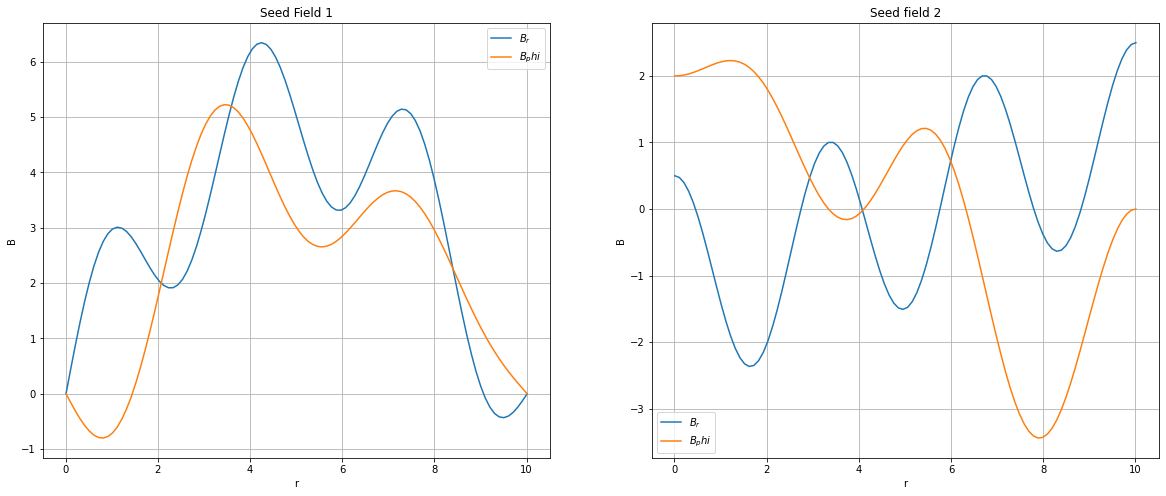

In [128]:
B0 = np.zeros((2, Nr))
B1 = np.zeros((2, Nr))
# trial 1 (sin wave and zero boundary condition)

def B_phi0_r1(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*5*np.pi)) - (np.sin(((r - r_i)/(r_f - r_i))*4*np.pi))

def B_r0_r1(r, phi, z):
    return (4*np.sin(((r - r_i)/(r_f - r_i))*np.pi)) + (1.5*np.sin(((r - r_i)/(r_f - r_i))*6*np.pi)) + ( np.sin(((r - r_i)/(r_f - r_i))*1*np.pi))

B0[0, :] = B_r0_r1(r, 0, 0) # first row is B_r
B0[1, :] = B_phi0_r1(r, 0, 0) # second row is B_phi

# trial 2 (cos wave and non-zero boundary condition)

def B_phi0_r2(r, phi, z):
    return (2*np.cos(((r - r_i)/(r_f - r_i))*np.pi)) - (np.cos(((r - r_i)/(r_f - r_i))*5*np.pi)) + (np.cos(((r - r_i)/(r_f - r_i))*4*np.pi))

def B_r0_r2(r, phi, z):
    return (-2*np.cos(((r - r_i)/(r_f - r_i))*np.pi)) + (1.5*np.cos(((r - r_i)/(r_f - r_i))*6*np.pi)) + ( np.cos(((r - r_i)/(r_f - r_i))*1*np.pi))

B1[0, :] = B_r0_r2(r, 0, 0) # first row is B_r
B1[1, :] = B_phi0_r2(r, 0, 0) # second row is B_phi

fig, axs = plt.subplots(1,2, figsize=(20, 8))
axs[0].set_title(r'Seed Field 1')
axs[0].set_xlabel(r'r')
axs[0].set_ylabel(r'B')
axs[0].plot(r, B0[0, :], label = '$B_r$')
axs[0].plot(r, B0[1, :], label = '$B_phi$')
axs[0].grid(True)
axs[0].legend()

axs[1].set_title(r'Seed field 2')
axs[1].set_xlabel(r'r')
axs[1].set_ylabel(r'B')
axs[1].plot(r, B1[0, :], label = '$B_r$')
axs[1].plot(r, B1[1, :], label = '$B_phi$')
axs[1].grid(True)
axs[1].legend()


if fig_save:
    plt.savefig(fig_path + "B_trial_IC.png")
plt.show()

In [153]:

B_list1 = sim_field(r_i, r_f, Nr, T, Nt_r, B_r0_r1, B_phi0_r1, dBdt_r, order, ghost_zone_type, iterations_to_save=iterations_to_save_2)

B_list2 = sim_field(r_i, r_f, Nr, T, Nt_r, B_r0_r2, B_phi0_r2, dBdt_r, order, ghost_zone_type, iterations_to_save=iterations_to_save_2)


100%|██████████| 5000/5000 [00:05<00:00, 853.03it/s]


<Figure size 432x288 with 0 Axes>

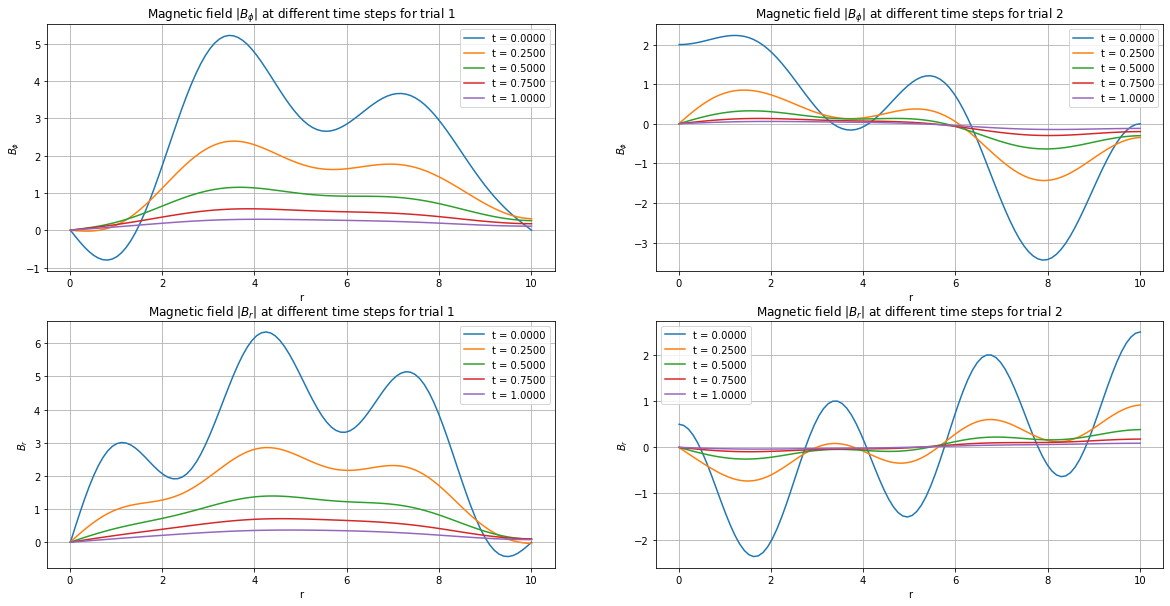

In [157]:
# plotting the magnetic fields at different time steps (figures side by side)

plt.suptitle('Magnetic field $|B_{\phi}|$ and $|B_{r}|$ at different time steps for both Trials')
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].set_title(r'Magnetic field $|B_{\phi}|$ at different time steps for trial 1')
axs[0, 0].set_xlabel(r'r')
axs[0, 0].set_ylabel(r'$B_{\phi}$')
for i in range(len(iterations_to_save_2)):
    axs[0, 0].plot(np.linspace(r_i, r_f, Nr), B_list1[i, 1, :], label=f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
axs[0, 0].grid(True)
axs[0, 0].legend()

# r-implementation B-phi
axs[0, 1].set_title(r'Magnetic field $|B_{\phi}|$ at different time steps for trial 2')
axs[0, 1].set_xlabel(r'r')
axs[0, 1].set_ylabel(r'$B_{\phi}$')
for i in range(len(iterations_to_save_2)):
    axs[0, 1].plot(np.linspace(r_i, r_f, Nr), B_list2[i, 1, :], label=f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].set_title(r'Magnetic field $|B_{r}|$ at different time steps for trial 1')
axs[1, 0].set_xlabel(r'r')
axs[1, 0].set_ylabel(r'$B_{r}$')
for i in range(len(iterations_to_save_2)):
    axs[1, 0].plot(np.linspace(r_i, r_f, Nr), B_list1[i, 0, :], label=f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
axs[1, 0].grid(True)
axs[1, 0].legend()

# r-implementation B_r
axs[1, 1].set_title(r'Magnetic field $|B_{r}|$ at different time steps for trial 2')
axs[1, 1].set_xlabel(r'r')
axs[1, 1].set_ylabel(r'$B_{r}$')
for i in range(len(iterations_to_save_2)):
    axs[1, 1].plot(np.linspace(r_i, r_f, Nr), B_list2[i, 0, :], label=f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
axs[1, 1].grid(True)
axs[1, 1].legend()
if fig_save:
    plt.savefig(fig_path + "Bphi_Br_evol_trials.png")
plt.show()



#### As evident in the implementation of the $r$ function, the boundary conditions are not effectively maintained due to the nature of the equation. The ghost zones, designed to approximate relative anti-symmetric conditions, primarily manage to maintain a zero second derivative at the boundaries. However, given that the equation involves both first and second derivatives alongside the function itself, the ghost zones struggle to adequately preserve the boundary conditions. This results in a noticeable decay of the magnetic field over time, despite utilizing different initial seed fields in the implementations.

<Figure size 432x288 with 0 Axes>

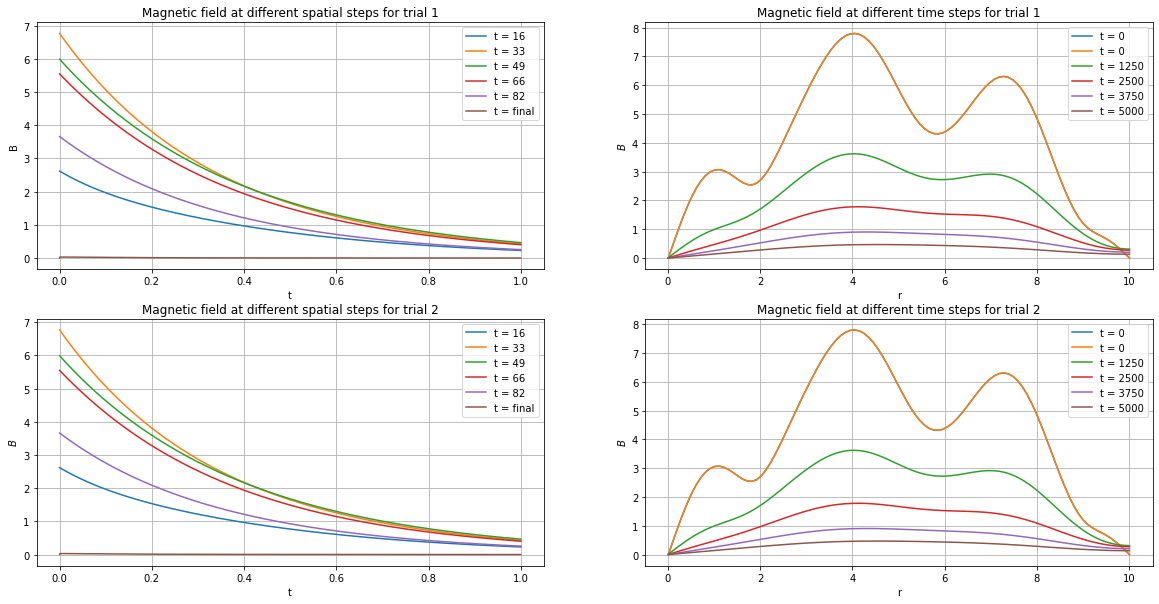

In [158]:
B_tot1 = B_total(B_list1)
B_tot2 = B_total(B_list2)


plt.suptitle('Magnetic field evolution for both Trials')
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].set_title(r'Magnetic field at different spatial steps for trial 1')
axs[0, 0].set_xlabel(r't')
axs[0, 0].set_ylabel(r'B')

for i in range(len(space_steps_to_save)):
    axs[0, 0].plot(t_r, B_tot1[:,space_steps_to_save[i]], label = f't = {space_steps_to_save[i]}')
axs[0, 0].plot(t_r, B_tot1[:,0],label = f't = final')
axs[0, 0].grid(True)
axs[0, 0].legend()

# r-implementation B-phi
axs[0, 1].set_title(r'Magnetic field at different time steps for trial 1')
axs[0, 1].set_xlabel(r'r')
axs[0, 1].set_ylabel(r'$B$')
axs[0, 1].plot(r, B_tot1[0,:],label = f't = 0')
for i in range(len(iterations_to_save2)):
    axs[0, 1].plot(np.linspace(r_i, r_f, Nr), B_tot1[iterations_to_save2[i],:], label = f't = {iterations_to_save2[i]}')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].set_title(r'Magnetic field at different spatial steps for trial 2')
axs[1, 0].set_xlabel(r't')
axs[1, 0].set_ylabel(r'$B$')

for i in range(len(space_steps_to_save)):
    axs[1, 0].plot(t_r, B_tot2[:,space_steps_to_save[i]], label = f't = {space_steps_to_save[i]}')
axs[1, 0].plot(t_r, B_tot2[:,0],label = f't = final')
axs[1, 0].grid(True)
axs[1, 0].legend()

# r-implementation B_r
axs[1, 1].set_title(r'Magnetic field at different time steps for trial 2')
axs[1, 1].set_xlabel(r'r')
axs[1, 1].set_ylabel(r'$B$')
axs[1, 1].plot(r, B_tot2[0,:],label = f't = 0')
for i in range(len(iterations_to_save2)):
    axs[1, 1].plot(np.linspace(r_i, r_f, Nr), B_tot2[iterations_to_save2[i],:], label = f't = {iterations_to_save2[i]}')
axs[1, 1].grid(True)
axs[1, 1].legend()
if fig_save:
    plt.savefig(fig_path + "B_evolution_trials2.png")
plt.show()



### Exploring Different Ghost zone Boundary conditions

In [144]:

# simulating the time evolution of the magnetic field with different ghost zone types
B_list1 = sim_field(r_i, r_f, Nr, T, Nt_r, B_r0_r1, B_phi0_r1, dBdt_r, order = order, ghost_zone_type = 'anti-symmetric', iterations_to_save = iterations_to_save)
B_list2 = sim_field(r_i, r_f, Nr, T, Nt_r, B_r0_r1, B_phi0_r1, dBdt_r, order = order, ghost_zone_type = 'symmetric', iterations_to_save = iterations_to_save)


100%|██████████| 5000/5000 [00:06<00:00, 828.37it/s]


<Figure size 432x288 with 0 Axes>

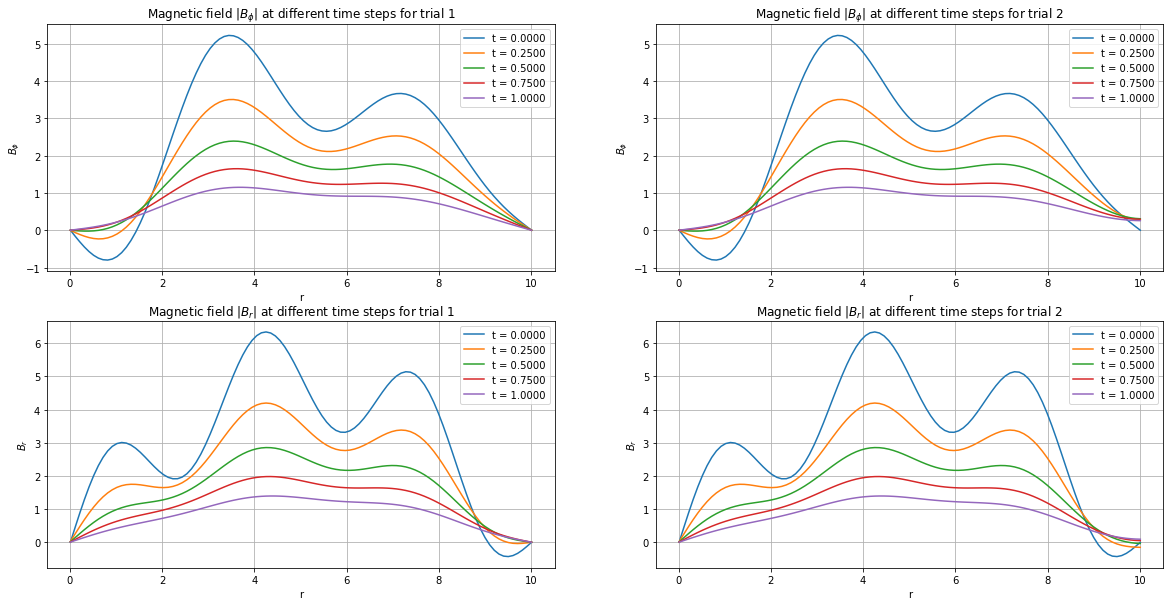

In [145]:
# plotting the magnetic fields at different time steps (figures side by side)

plt.suptitle('Magnetic field $|B_{\phi}|$ and $|B_{r}|$ at different time steps for both Trials')
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].set_title(r'Magnetic field $|B_{\phi}|$ at different time steps for trial 1')
axs[0, 0].set_xlabel(r'r')
axs[0, 0].set_ylabel(r'$B_{\phi}$')
for i in range(len(iterations_to_save_2)):
    axs[0, 0].plot(np.linspace(r_i, r_f, Nr), B_list1[i, 1, :], label=f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
axs[0, 0].grid(True)
axs[0, 0].legend()

# r-implementation B-phi
axs[0, 1].set_title(r'Magnetic field $|B_{\phi}|$ at different time steps for trial 2')
axs[0, 1].set_xlabel(r'r')
axs[0, 1].set_ylabel(r'$B_{\phi}$')
for i in range(len(iterations_to_save_2)):
    axs[0, 1].plot(np.linspace(r_i, r_f, Nr), B_list2[i, 1, :], label=f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].set_title(r'Magnetic field $|B_{r}|$ at different time steps for trial 1')
axs[1, 0].set_xlabel(r'r')
axs[1, 0].set_ylabel(r'$B_{r}$')
for i in range(len(iterations_to_save_2)):
    axs[1, 0].plot(np.linspace(r_i, r_f, Nr), B_list1[i, 0, :], label=f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
axs[1, 0].grid(True)
axs[1, 0].legend()

# r-implementation B_r
axs[1, 1].set_title(r'Magnetic field $|B_{r}|$ at different time steps for trial 2')
axs[1, 1].set_xlabel(r'r')
axs[1, 1].set_ylabel(r'$B_{r}$')
for i in range(len(iterations_to_save_2)):
    axs[1, 1].plot(np.linspace(r_i, r_f, Nr), B_list2[i, 0, :], label=f't = {iterations_to_save_2[i] * T / Nt_r:.4f}')
axs[1, 1].grid(True)
axs[1, 1].legend()
if fig_save:
    plt.savefig(fig_path + "Bphi_Br_evol_trials.png")
plt.show()



<Figure size 432x288 with 0 Axes>

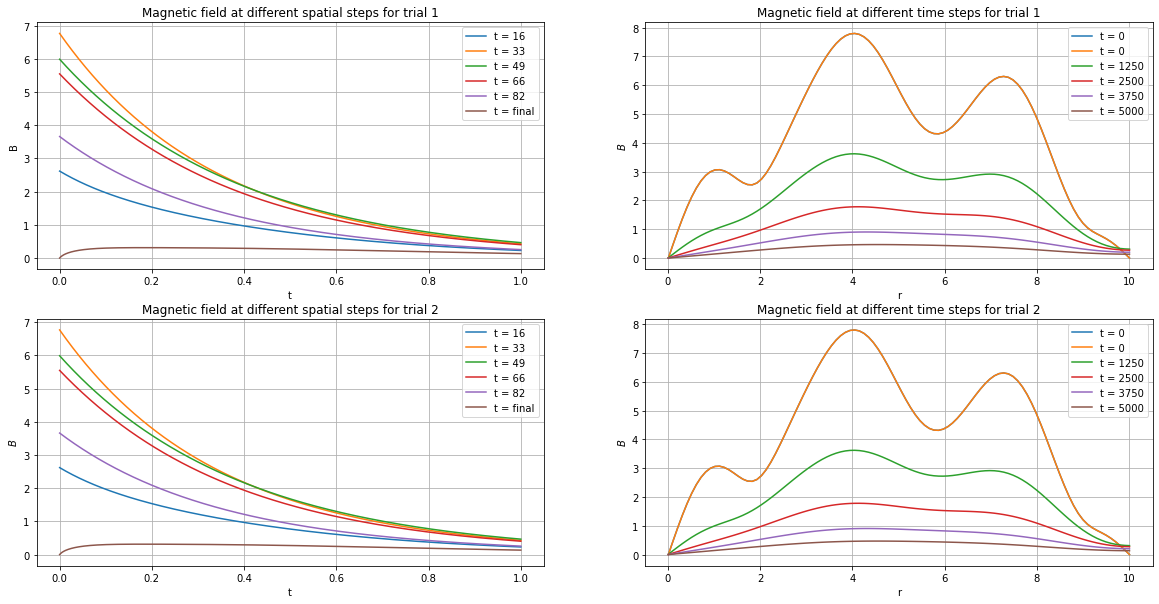

In [150]:
B_tot1 = B_total(B_list1)
B_tot2 = B_total(B_list2)


plt.suptitle('Magnetic field evolution for both Trials')
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].set_title(r'Magnetic field at different spatial steps for trial 1')
axs[0, 0].set_xlabel(r't')
axs[0, 0].set_ylabel(r'B')

for i in range(len(space_steps_to_save)):
    axs[0, 0].plot(t_r, B_tot1[:,space_steps_to_save[i]], label = f't = {space_steps_to_save[i]}')
axs[0, 0].plot(t_r, B_tot1[:,-1],label = f't = final')
axs[0, 0].grid(True)
axs[0, 0].legend()

# r-implementation B-phi
axs[0, 1].set_title(r'Magnetic field at different time steps for trial 1')
axs[0, 1].set_xlabel(r'r')
axs[0, 1].set_ylabel(r'$B$')
axs[0, 1].plot(r, B_tot1[0,:],label = f't = 0')
for i in range(len(iterations_to_save2)):
    axs[0, 1].plot(np.linspace(r_i, r_f, Nr), B_tot1[iterations_to_save2[i],:], label = f't = {iterations_to_save2[i]}')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].set_title(r'Magnetic field at different spatial steps for trial 2')
axs[1, 0].set_xlabel(r't')
axs[1, 0].set_ylabel(r'$B$')

for i in range(len(space_steps_to_save)):
    axs[1, 0].plot(t_r, B_tot2[:,space_steps_to_save[i]], label = f't = {space_steps_to_save[i]}')
axs[1, 0].plot(t_r, B_tot2[:,-1],label = f't = final')
axs[1, 0].grid(True)
axs[1, 0].legend()

# r-implementation B_r
axs[1, 1].set_title(r'Magnetic field at different time steps for trial 2')
axs[1, 1].set_xlabel(r'r')
axs[1, 1].set_ylabel(r'$B$')
axs[1, 1].plot(r, B_tot2[0,:],label = f't = 0')
for i in range(len(iterations_to_save2)):
    axs[1, 1].plot(np.linspace(r_i, r_f, Nr), B_tot2[iterations_to_save2[i],:], label = f't = {iterations_to_save2[i]}')
axs[1, 1].grid(True)
axs[1, 1].legend()
if fig_save:
    plt.savefig(fig_path + "B_evolution_trials2.png")
plt.show()

